# Control Run Analysis

Computation of the potential prognostic predictability (PPP) for metrics from the control simulation, eventually using pre-built functions in project folder. 

**Important metrics:** <br>
- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2 <-- *this is what I started with*
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

**Steps:** <br>
- open dataset, including all files in control directory for specified variable
- compute climatology + rename variable (var --> var_clim)
- compute anomalies + rename variable (var --> var_anom)
- compute variance &emsp; $\sigma^{2} = \frac{\sum (X - \mu)^{2}}{N}$
    * mean of anomalies, by month
    * deviation of each anomaly data point, compared to monthly mean anomaly
    * square the deviations
    * sum the deviations, by month
    * divide these sums by number of years (300 in our case) <-- figure out how to keep NaN values, and stop conversion to 0s
- merge climatology, anomalies, variance, and original datasets (```compat = 'override'```)
- write this dataset to a NetCDF file

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
# compute the climatology (time mean for each month)
def compute_ctrl_clim(ds):
    return ds.groupby('time.month').mean(dim='time')


# compute the monthly anomalies from the 300-year control runs
def compute_ctrl_anom(ds):
    clim = ds.groupby('time.month').mean(dim='time')
    return ds.groupby('time.month') - clim

In [220]:
def grid_ctrl_runs(path, var):
    ds = xr.open_mfdataset(path)

    ## compute climatology
    time = 'time'
    try:
        clim = ds.groupby(time+'.month').mean(dim=time)

    except:
        time = time.upper()
        clim = ds.groupby(time+'.month').mean(dim=time)

    ## compute anomalies
    anom = ds.groupby(time+'.month') - clim

    ## rename data variables
    clim = clim.rename({var:var+'_clim'})
    var_anom = var+'_anom'
    anom = anom.rename({var:var+'_anom'})

    ## compute variance
    mean = anom.groupby(time+'.month').mean(dim=time)
    dev = anom.groupby(time+'.month') - mean
    dev2 = dev.assign(sqr = dev[var_anom]**2)
    dev2_sum = dev2.groupby(time+'.month').sum()
    variance = dev2_sum.assign(v=dev2_sum[var_anom] / 300)

    variance = variance.rename({'v':var+'_variance'})
    variance = variance.drop_vars('sqr')
    variance = variance.drop_vars(var_anom)

    ## merge climatology, anomaly, and variance data with the original dataset
    ds_metrics = ds.merge(clim, compat='override')
    ds_metrics = ds_metrics.merge(anom, compat='override')
    ds_metrics = ds_metrics.merge(variance, compat='override')

    ## write to a NetCDF file (where?)
#     write_path = ??
#     filename = var.upper() + 'GRID_CTRL_PPE_metrics.nc'
#     ds_metrics.to_netcdf(write_path+filename)
    
    return ds_metrics

## Gridpoint-level Fields

In [5]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

#### Sea Surface Temperature (SST)

In [92]:
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
var_sst = 'sst'
grid_SST_metrics = grid_ctrl_runs(path_sst, var_sst)

#### Sea Surface Salinity (SSS)

In [93]:
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
var_sss = 'sss'
grid_SSS_metrics = grid_ctrl_runs(path_sss, var_sss)

#### Sea-ice Concentration (CN)
Summed over all thickness categories(?)

In [94]:
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'
grid_CN_INV_metrics = grid_ctrl_runs(path_cn, var_cn)

#### Net Primary Production (NPP)

In [96]:
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'
grid_NPP_metrics = grid_ctrl_runs(path_npp, var_npp)

#### Surface pCO$_2$ (PCO2SURF)

In [97]:
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'
grid_PCO2SURF_metrics = grid_ctrl_runs(path_pco2surf, var_pco2surf)

## Southern Hemisphere Sea Ice Extent and Volume
Using sea-ice extent (EXT) and sea-ice thickness (HI) with ocean/ice model grid information.

### Sea Ice Extent

In [322]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
cn_ds = xr.open_mfdataset(path_cn)

## create mask for SIE where SIC > 15%
SIE_binary = xr.where(cn_ds.CN_INV > 0.15, 1, 0)

## replace values over land with NaN
SIE_binary = xr.where(np.isnan(cn_ds.CN_INV), np.nan, extent)

cn_ds = cn_ds.assign(SIE_binary=SIE_binary)
cn_ds = cn_ds.rename({'XT':'xt', 'YT':'yt'})

In [323]:
subdir_grid = 'GRID/'

ice_grid = xr.open_dataset(rootdir+subdir_grid+'ice_month.static.nc')

ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')
# mask_arr = xr.where(np.isnan(ocean_grid.ht), 0.0, 1.0)
# ocean_grid.coords['mask'] = (('yt_ocean', 'xt_ocean'), mask_arr)
# ocean_grid.mask.attrs['valid_range'] = '[0,1]'

In [397]:
## get the area of sea ice
area_SIE = cn_ds.SIE_binary * ice_grid.area

## limit to just the Southern Hemisphere (for summation purposes)
SH_area_SIE = area_SIE.where(area_SIE.yt < 0)


## SIE climatology - field (values at individual grid points)
SIE_field_clim = SH_area_SIE.groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - field
SIE_field_anom = SH_area_SIE.groupby('TIME.month') - SIE_field_clim


## SIE climatology - single areal sum (total area covered by sea ice in Southern Hemisphere)
SIE_sum_clim = SH_area_SIE.sum(dim={'xt', 'yt'}).groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - single area sum
SIE_sum_anom = SH_area_SIE.sum(dim={'xt', 'yt'}).groupby('TIME.month') - SIE_sum_clim

### Sea Ice Volume

In [398]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_hi = rootdir+subdir_ctrl+'/HI/HI_0001_0300.nc'
hi_ds = xr.open_mfdataset(path_hi)

hi_ds = hi_ds.rename({'time':'TIME'})

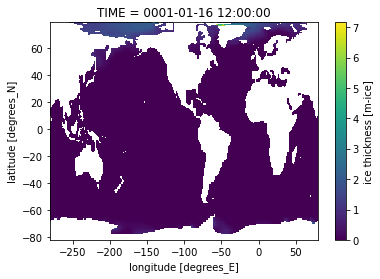

In [411]:
hi_ds.HI[0].plot()

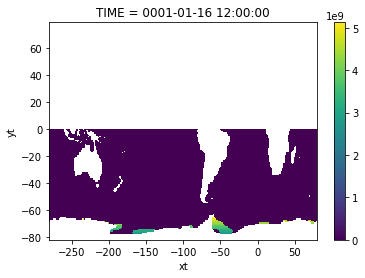

In [412]:
SH_area_SIE[0].plot()

In [407]:
SI_vol = hi_ds.HI * SH_area_SIE

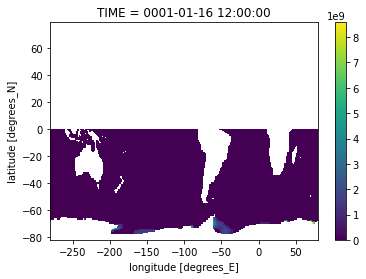

In [413]:
SI_vol[0].plot()

In [408]:
SI_vol[0].sum(dim={'xt', 'yt'}).values

array(6.39120299e+11)

In [409]:
SH_area_SIE[0].sum(dim={'xt', 'yt'}).values

array(1.36844554e+12)

**^^ don't think this (sea ice volume < sea ice extent) makes any sense. I need to take another look at my methods here.**